# Comparing overturning circulation in ACCESS-OM3 with ACCESS-OM2

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime

In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [3]:
datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    datastore_path,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [4]:
vmo = datastore.search(variable="vmo").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

## Load ACCESS-OM2 data from catalog

Note that this simulation doesn't have the GM component of the overturning as a diagnostic - it has GM switched on, but not diagnosed.

In [5]:
catalog = intake.cat.access_nri

In [6]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='ty_trans_rho',frequency="1yr")
ty_trans_rho=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

## 10-year mean overturning streamfunction

In [7]:
psi_OM3 = (
    vmo["vmo"]
    .sel(time=slice("1940-01-01", "1949-12-31"))
    .mean("time")
    .sum("xh")
    .cumsum("rho2_l")
    .load()
    / 1025
    / 1e6
)

In [8]:
psi_OM2 = (
    ty_trans_rho["ty_trans_rho"]
    .sel(time=slice("1940-01-01", "1949-12-31"))
    .mean("time")
    .sum("grid_xt_ocean")
    .cumsum("potrho")
    .load()
    / 1025
    / 1e6
)

Text(0.5, 1.0, '(b) Overturning in ACCESS-OM3')

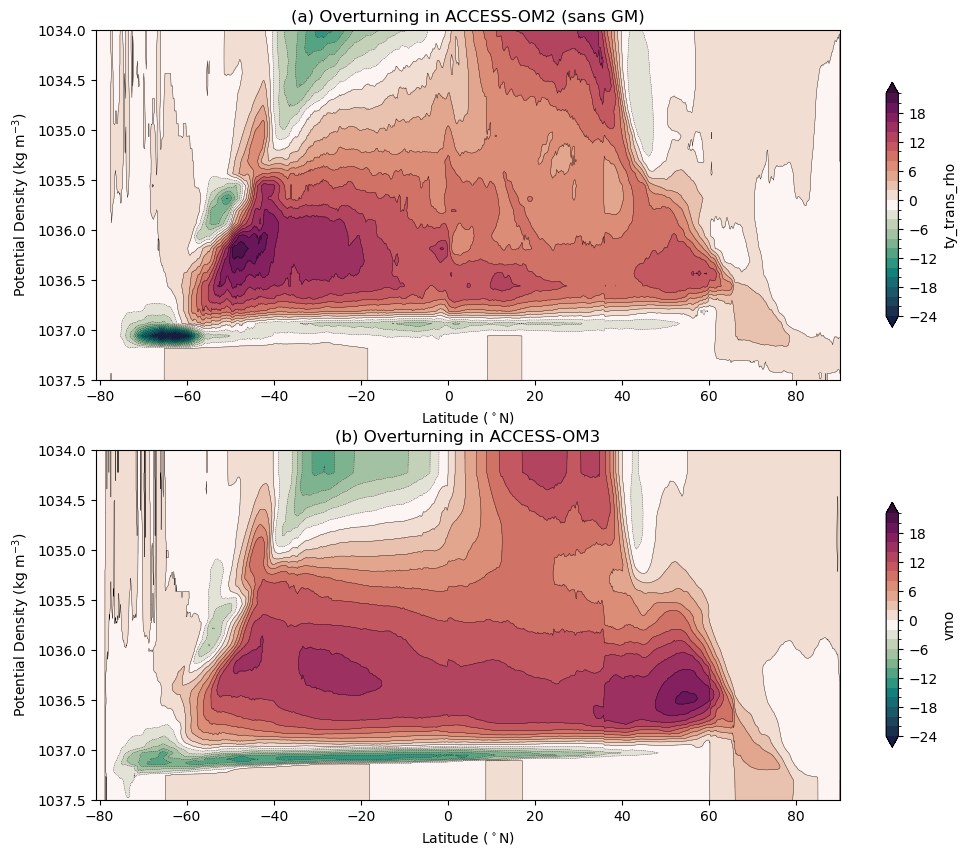

In [9]:
plt.figure(figsize=(12, 10))
levels = range(-24, 24, 2)
plt.subplot(211)
psi_OM2.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both", cbar_kwargs={"shrink": 0.7}
)
psi_OM2.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
plt.title("(a) Overturning in ACCESS-OM2 (sans GM)")

plt.subplot(212)
psi_OM3.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both", cbar_kwargs={"shrink": 0.7}
)
psi_OM3.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
plt.title("(b) Overturning in ACCESS-OM3")

## Timeseries of overturning at key latitudes

In [10]:
psi_time_OM3 = vmo["vmo"].sum("xh").cumsum("rho2_l") / 1025 / 1e6
psi_30S_OM3 = (
    psi_time_OM3.sel(yq=-30, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_26N_OM3 = (
    psi_time_OM3.sel(yq=26, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_55N_OM3 = (
    psi_time_OM3.sel(yq=5, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_abyss_OM3 = (
    -psi_time_OM3.sel(yq=-40, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .min(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)

In [11]:
psi_time_OM2 = ty_trans_rho["ty_trans_rho"].sum("grid_xt_ocean").cumsum("potrho") / 1025 / 1e6
psi_30S_OM2 = (
    psi_time_OM2
    .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=-30, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .load()
)
psi_26N_OM2 = (
    psi_time_OM2
    .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=26, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .load()
)
psi_55N_OM2 = (
    psi_time_OM2
    .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=55, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .load()
)
psi_abyss_OM2 = (
    -psi_time_OM2
    .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=-40, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .min(dim="potrho")
    .load()
)

Text(0, 0.5, '')

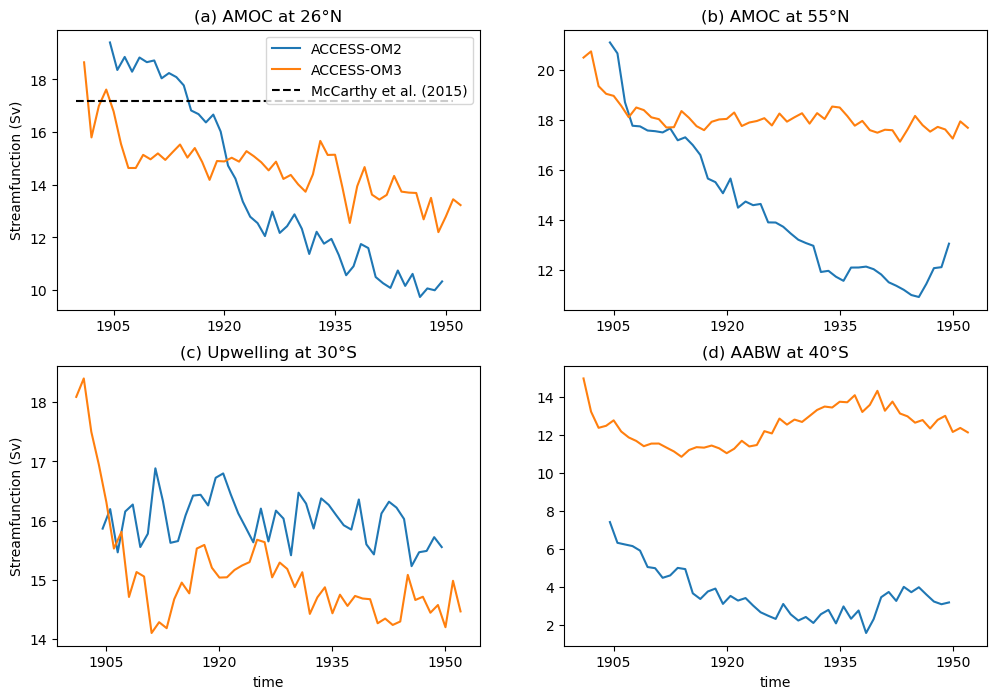

In [12]:
plt.figure(figsize=(12, 8)) 

plt.subplot(221)
psi_26N_OM2.plot(label='ACCESS-OM2')
psi_26N_OM3.plot(label='ACCESS-OM3')
plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [17.2, 17.2],
           'k--', label="McCarthy et al. (2015)")
plt.title('(a) AMOC at 26°N')
plt.ylabel('Streamfunction (Sv)')
plt.legend()
plt.xlabel('')

plt.subplot(222)
psi_55N_OM2.plot()
psi_55N_OM3.plot()
plt.title('(b) AMOC at 55°N')
plt.ylabel('')
plt.xlabel('')

plt.subplot(223)
psi_30S_OM2.plot()
psi_30S_OM3.plot()
plt.title('(c) Upwelling at 30°S')
plt.ylabel('Streamfunction (Sv)')

plt.subplot(224)
psi_abyss_OM2.plot()
psi_abyss_OM3.plot()
plt.title('(d) AABW at 40°S')
plt.ylabel('')


In [13]:
client.close()